In [12]:
import tensorflow as tf
from tensorflow import keras
from numpy.random import seed
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import History
from keras.callbacks import LearningRateScheduler
from sklearn.metrics import accuracy_score
from keras.optimizers import Adam

In [2]:
seed(123)

Wczytanie danych, usunięcie brakujących wartości, nadanie etykiet

In [3]:
train_set = pd.read_csv('adult/adult.data', sep=", ", header=None, engine='python')
test_set = pd.read_csv('adult/adult.test', sep=", ", skiprows=1, header=None, engine='python')

col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation',
              'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
              'wage_class']

train_set.columns = col_labels
test_set.columns = col_labels

train = train_set.replace('?', np.nan).dropna()
test = test_set.replace('?', np.nan).dropna()

train_set.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Szybki preprocessing

In [4]:
dataset = pd.concat([train, test])

dataset['wage_class'] = dataset.wage_class.replace({'<=50K.': 0, '<=50K': 0, '>50K.': 1, '>50K': 1})

dataset.drop(["fnlwgt"], axis=1, inplace=True)
dataset.drop(["education"], axis=1, inplace=True)

x = dataset.groupby('native_country')["wage_class"].mean()
d = dict(pd.cut(x[x.index != " United-States"], 5, labels=range(5)))
dataset['native_country'] = dataset['native_country'].replace(d)

dataset = pd.get_dummies(dataset, drop_first=True)

train = dataset.iloc[:train.shape[0]]
test = dataset.iloc[train.shape[0]:]

X_train = train.drop("wage_class", axis=1)
y_train = train.wage_class

X_test = test.drop("wage_class", axis=1)
y_test = test.wage_class

Stadardyzacja

In [5]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

print(f"X_train shape:\t{X_train.shape}")
print(f"X_test shape:\t{X_test.shape}")

X_train shape:	(30162, 41)
X_test shape:	(15060, 41)


# SGD

In [6]:
history_sgd = History()
model = Sequential()
model.add(Dense(100,activation="sigmoid",input_shape=(X_train.shape[1],)))
model.add(Dense(50,activation="sigmoid"))
model.add(Dense(10,activation="sigmoid"))
model.add(Dense(1,activation="sigmoid"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               4200      
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 10)                510       


2024-06-07 14:22:12.392475: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-06-07 14:22:12.392927: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2024-06-07 14:22:12.392956: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (kjUbuntu): /proc/driver/nvidia/version does not exist
2024-06-07 14:22:12.393771: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 9,771
Trainable params: 9,771
Non-trainable params: 0
_________________________________________________________________


In [9]:
sgd = tf.keras.optimizers.legacy.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss="binary_crossentropy",optimizer=sgd, metrics=["accuracy"])

In [11]:
model.fit(X_train, y_train, validation_data= (X_test, y_test), batch_size=32,epochs=50, callbacks=[history_sgd])

Epoch 1/50
943/943 [==============================] - 5s 5ms/step - loss: 0.3288 - accuracy: 0.8471 - val_loss: 0.3283 - val_accuracy: 0.8468
Epoch 2/50
943/943 [==============================] - 4s 4ms/step - loss: 0.3272 - accuracy: 0.8459 - val_loss: 0.3287 - val_accuracy: 0.8448
Epoch 3/50
943/943 [==============================] - 5s 5ms/step - loss: 0.3264 - accuracy: 0.8467 - val_loss: 0.3274 - val_accuracy: 0.8462
Epoch 4/50
943/943 [==============================] - 5s 5ms/step - loss: 0.3254 - accuracy: 0.8469 - val_loss: 0.3275 - val_accuracy: 0.8468
Epoch 5/50
943/943 [==============================] - 4s 4ms/step - loss: 0.3242 - accuracy: 0.8475 - val_loss: 0.3346 - val_accuracy: 0.8406
Epoch 6/50
943/943 [==============================] - 4s 4ms/step - loss: 0.3238 - accuracy: 0.8489 - val_loss: 0.3247 - val_accuracy: 0.8469
Epoch 7/50
943/943 [==============================] - 4s 4ms/step - loss: 0.3230 - accuracy: 0.8487 - val_loss: 0.3254 - val_accuracy: 0.8469
Epoch 

In [13]:
history_sgd.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

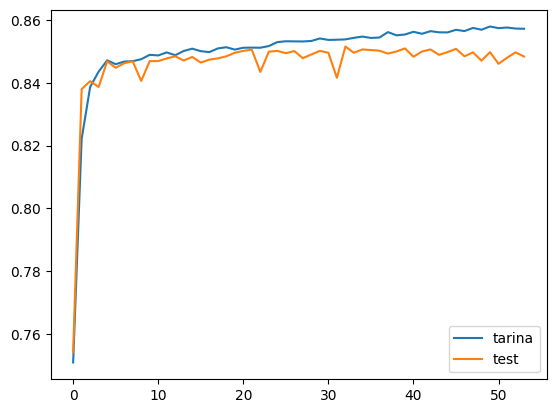

In [14]:
plt.plot(history_sgd.history['accuracy'], label = "tarina")
plt.plot(history_sgd.history['val_accuracy'], label = "test")
plt.legend()
plt.show()

# Zad

Użyjmy LearningRateScheduler

In [15]:
# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.01
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * np.power(drop, np.floor((1+epoch)/epochs_drop))
    return lrate

history_lr_1 = History()
model = Sequential()
model.add(Dense(100,activation="sigmoid",input_shape=(X_train.shape[1],)))
model.add(Dense(50,activation="sigmoid"))
model.add(Dense(10,activation="sigmoid"))
model.add(Dense(1,activation="sigmoid"))
model.summary()

# sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss="binary_crossentropy",optimizer="SGD", metrics=["accuracy"])

lrate = LearningRateScheduler(step_decay)
model.fit(X_train, y_train, validation_data= (X_test, y_test), batch_size=32,epochs=100, callbacks=[lrate, history_lr_1])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 100)               4200      
                                                                 
 dense_5 (Dense)             (None, 50)                5050      
                                                                 
 dense_6 (Dense)             (None, 10)                510       
                                                                 
 dense_7 (Dense)             (None, 1)                 11        
                                                                 
Total params: 9,771
Trainable params: 9,771
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
943/943 [==============================] - 6s 6ms/step - loss: 0.5803 - accuracy: 0.7257 - val_loss: 0.5564 - val_accuracy: 0.7543 - lr: 0.0100
Epoch 2/100
943/943 [=======

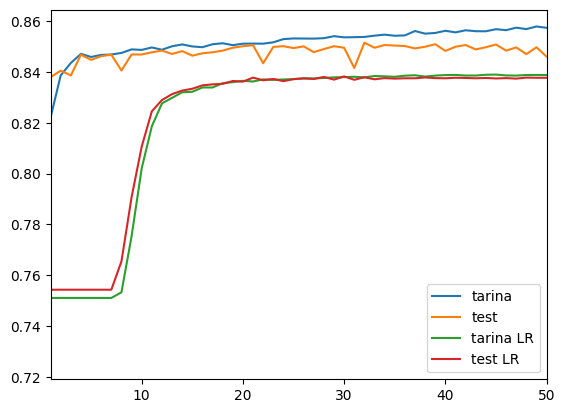

In [22]:
import matplotlib.pyplot as pl
plt.plot(history_sgd.history['accuracy'], label = "tarina")
plt.plot(history_sgd.history['val_accuracy'], label = "test")

plt.plot(history_lr_1.history['accuracy'], label = "tarina LR")
plt.plot(history_lr_1.history['val_accuracy'], label = "test LR")
plt.xlim(1, 50)
plt.legend()
plt.show()

# Zad

Wykonaj analogiczne zadanie dla 
* Adam bez LearningRateScheduler i learning_rate=0.001
* Adam z użyciem LearningRateScheduler i learning_rate=0.001
* Adam z użyciem LearningRateScheduler i learning_rate=0.0001

Zwizualizuj wyniki:

* porównaj krzywe uczenia

In [17]:
# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.01
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * np.power(drop, np.floor((1 + epoch) / epochs_drop))
    return lrate

In [18]:
def create_model():
    model = Sequential()
    model.add(Dense(100,activation="sigmoid",input_shape=(X_train.shape[1],)))
    model.add(Dense(50,activation="sigmoid"))
    model.add(Dense(10,activation="sigmoid"))
    model.add(Dense(1,activation="sigmoid"))
    return model


models_history_name = []

# Model 1: Adam without LearningRateScheduler and learning_rate=0.001
model1 = create_model()
model1.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])
history1 = model1.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=40)
models_history_name.append((history1, model1, "Adam 0.001"))

# Model 2: Adam with LearningRateScheduler and learning_rate=0.001
model2 = create_model()
model2.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])
lrate = LearningRateScheduler(step_decay)
history2 = model2.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=40, callbacks=[lrate])
models_history_name.append((history2, model2, "Adam 0.001 with scheduler"))

# Model 3: Adam with LearningRateScheduler and learning_rate=0.0001
model3 = create_model()
model3.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.0001), metrics=["accuracy"])
lrate = LearningRateScheduler(step_decay)
history3 = model3.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=40, callbacks=[lrate])
models_history_name.append((history3, model3, "Adam 0.0001 with scheduler"))

Epoch 1/40
943/943 [==============================] - 7s 6ms/step - loss: 0.3945 - accuracy: 0.8205 - val_loss: 0.3447 - val_accuracy: 0.8428
Epoch 2/40
943/943 [==============================] - 5s 6ms/step - loss: 0.3366 - accuracy: 0.8450 - val_loss: 0.3340 - val_accuracy: 0.8463
Epoch 3/40
943/943 [==============================] - 6s 7ms/step - loss: 0.3284 - accuracy: 0.8473 - val_loss: 0.3307 - val_accuracy: 0.8490
Epoch 4/40
943/943 [==============================] - 6s 6ms/step - loss: 0.3251 - accuracy: 0.8489 - val_loss: 0.3252 - val_accuracy: 0.8477
Epoch 5/40
943/943 [==============================] - 5s 6ms/step - loss: 0.3227 - accuracy: 0.8504 - val_loss: 0.3239 - val_accuracy: 0.8483
Epoch 6/40
943/943 [==============================] - 5s 6ms/step - loss: 0.3212 - accuracy: 0.8503 - val_loss: 0.3235 - val_accuracy: 0.8489
Epoch 7/40
943/943 [==============================] - 5s 5ms/step - loss: 0.3197 - accuracy: 0.8507 - val_loss: 0.3232 - val_accuracy: 0.8503
Epoch 

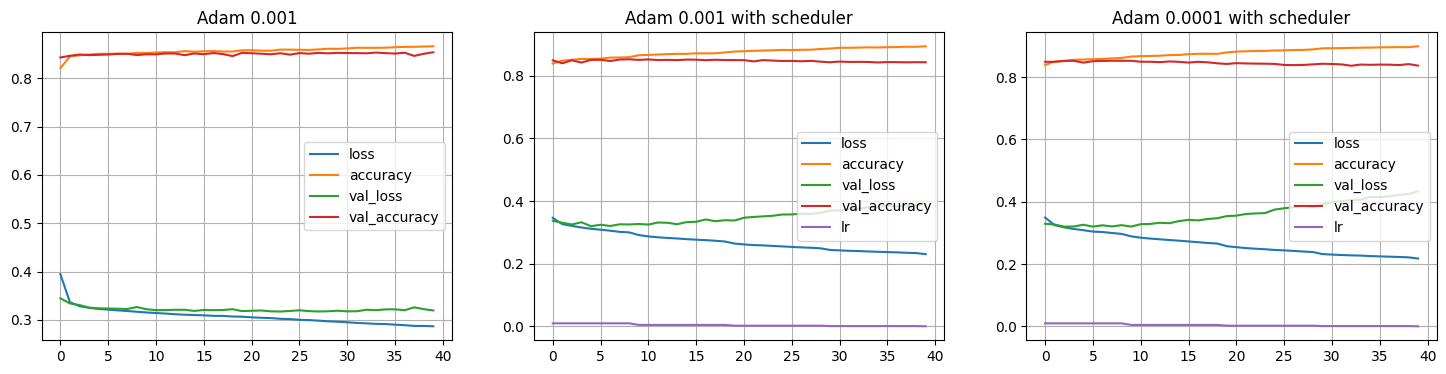

In [19]:
_, axs = plt.subplots(1, 3, figsize=(18, 4))

axs = axs.flatten()

for i, (history, model, name) in enumerate(models_history_name):
    pd.DataFrame(history.history).plot(ax=axs[i])
    axs[i].set_title(name)
    axs[i].grid(True)
    axs[i].legend()

In [20]:
df = pd.DataFrame(columns=["config", "accuracy"])

for i, (history, model, name) in enumerate(models_history_name):
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)
    accuracy = accuracy_score(y_test, y_pred)
    df.loc[i] = [name, accuracy]

df

471/471 [==============================] - 1s 2ms/step


,config,accuracy
0,Adam 0.001,0.754316
1,Adam 0.001 with scheduler,0.754316
2,Adam 0.0001 with scheduler,0.754316


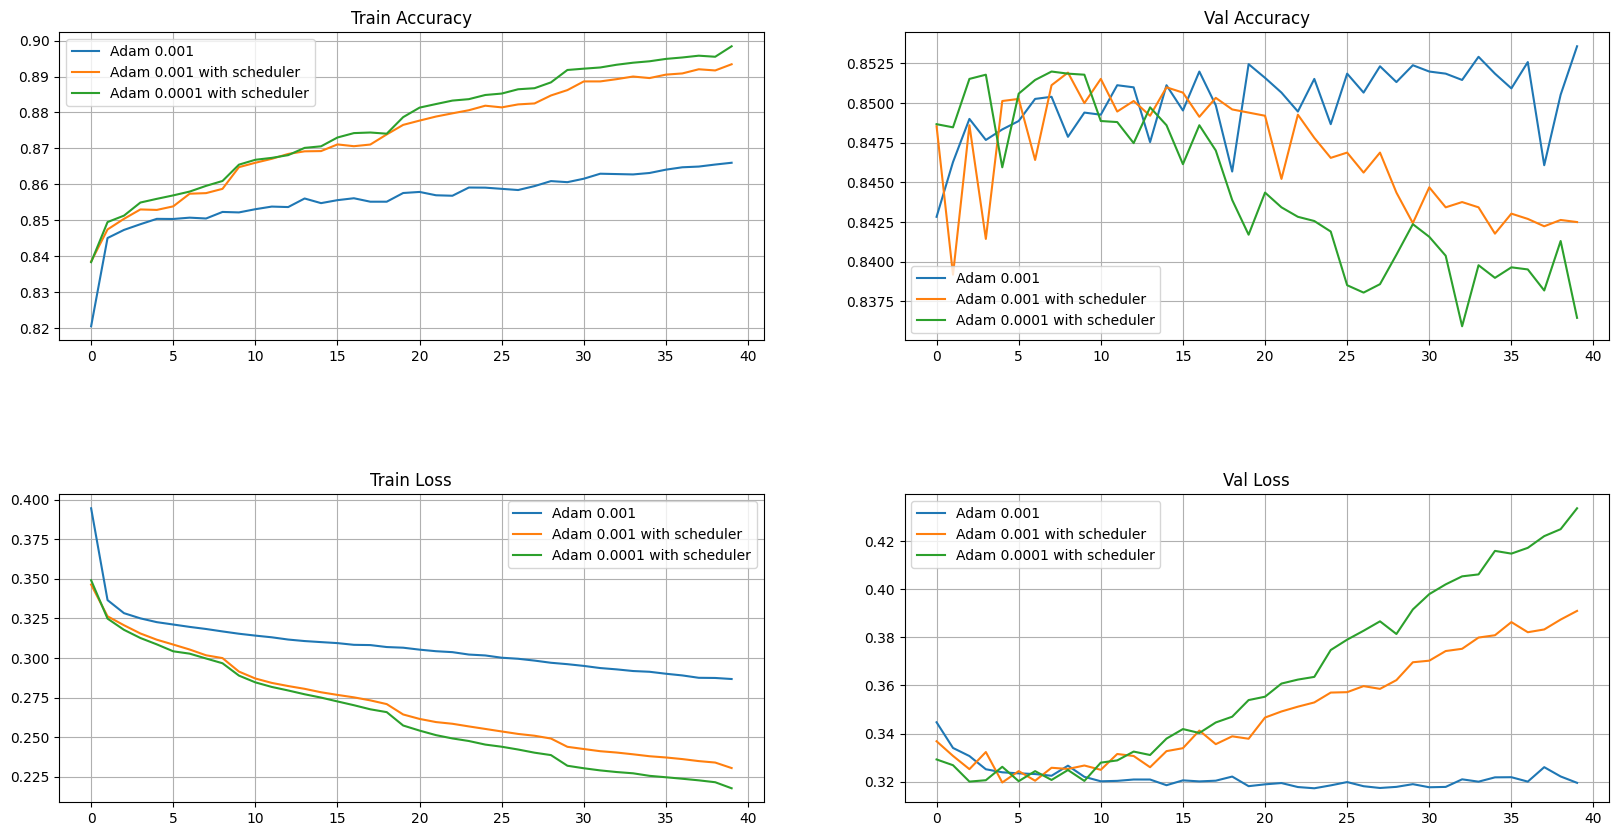

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10))

for i, (history, _, name) in enumerate(models_history_name):
    axs[0][0].plot(history.history['accuracy'], label=f'{name}')
    axs[0][1].plot(history.history['val_accuracy'], label=f'{name}')
    axs[1][0].plot(history.history['loss'], label=f'{name}')
    axs[1][1].plot(history.history['val_loss'], label=f'{name}')

axs[0][0].set_title('Train Accuracy')
axs[0][1].set_title('Val Accuracy')
axs[1][0].set_title('Train Loss')
axs[1][1].set_title('Val Loss')

for ax in axs.flatten():
    ax.legend()
    ax.grid(True)

plt.subplots_adjust(hspace=0.5)
plt.show()